In [82]:
import os
import json
import numpy as np
import pandas as pd
import scipy.io as sio
import mne
from mne.viz import plot_topomap
import matplotlib.pyplot as plt
import random
from scipy.signal import butter, filtfilt
from mne.time_frequency import tfr_multitaper
from mne.viz import plot_topomap
from pyriemann.classification import MDM  # Minimum Distance to Mean
from pyriemann.estimation import Covariances
from sklearn.metrics import accuracy_score, classification_report
from pyriemann.tangentspace import TangentSpace
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import shap

In [103]:
# Paths
DATA_DIR = './stroke-rehab'
participants = ['P1', 'P2', 'P3']
sessions = ['pre', 'post']
recordings = ['training', 'test']

# Epoching parameters
tmin = -2.0
tmax = 8.0
baseline = (-1.5, -0.5) # (-1.5, -0.5) with respect to cue
bp_low, bp_high = 8, 30  # Bandpass range
butter_low, butter_high = 8, 20  # For PSD plot

# Channel labels
ch_labels = [
    'FC3', 'FCz', 'FC4',
    'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',
    'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
    'Pz'
]

In [106]:
# Butterworth bandpass filter function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)

# Load and preprocess each training file
def load_and_segment(filepath):
    mat = sio.loadmat(filepath)
    y = mat['y']          # shape: (samples, channels)
    fs = float(mat['fs'].squeeze())
    trig = mat['trig'].squeeze() if 'trig' in mat else None

    if trig is None:
        return None  # No epochs in test data

    events = []
    samples_before = int(abs(tmin) * fs)
    samples_after = int(tmax * fs)
    epoch_len = samples_before + samples_after

    for i in range(1, len(trig)):
        if trig[i] != 0 and trig[i - 1] == 0:
            label = int(trig[i])
            start = i - samples_before
            stop = i + samples_after
            if start >= 0 and stop <= len(y):
                events.append((start, 0, 2 if label == 1 else 1))  # 2=left, 1=right

    events = np.array(events)
    epochs_data = np.array([
        y[start:start+epoch_len].T for (start, _, _) in events
    ])

    # Bandpass filter before creating MNE object (Butterworth 8-30 Hz)
    epochs_data = butter_bandpass_filter(epochs_data, bp_low, bp_high, fs, order=4)

    info = mne.create_info(ch_names=ch_labels, sfreq=fs, ch_types='eeg')
    epochs = mne.EpochsArray(epochs_data, info, events=events, event_id={'right': 1, 'left': 2}, tmin=tmin)
    epochs.set_montage('standard_1020')
    epochs.apply_baseline(baseline)

    return epochs

In [ ]:
# Load all data
dataset = {}
for p in participants:
    dataset[p] = {}
    for s in sessions:
        dataset[p][s] = {}
        for r in recordings:
            fname = f"{p}_{s}_{r}.mat"
            fpath = os.path.join(DATA_DIR, fname)
            epochs = load_and_segment(fpath)
            if epochs is not None:
                dataset[p][s][r] = epochs

Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Applyi

In [100]:
# For participant P1, condition 'pre'
epochs_train = dataset['P1']['pre']['training']
epochs_test = dataset['P1']['pre']['test']

# Get EEG data (epochs x channels x samples)
X_train = epochs_train.get_data()
X_test = epochs_test.get_data()

# Get labels: 1 (right), 2 (left)
y_train = epochs_train.events[:, -1]
y_test = epochs_test.events[:, -1]

print(f"Train shape: {X_train.shape}, Labels: {np.unique(y_train)}")
print(f"Test shape: {X_test.shape}, Labels: {np.unique(y_test)}")

Train shape: (80, 16, 2560), Labels: [1 2]
Test shape: (80, 16, 2560), Labels: [1 2]


The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


In [85]:
def compute_spd_matrices(eeg_data):

    epochs, channels, samples = eeg_data.shape
    spd_matrices = np.zeros((epochs, channels, channels))

    for i in range(epochs):
        epoch = eeg_data[i]  # shape (channels, samples)
        cov_matrix = np.cov(epoch)  # shape (channels, channels)
        # Optional: ensure SPD by adding a small regularization term to the diagonal
        cov_matrix += 1e-6 * np.eye(channels)
        spd_matrices[i] = cov_matrix

    return spd_matrices

In [87]:
y_train_spd = compute_spd_matrices(X_train)
y_test_spd = compute_spd_matrices(X_test)

In [88]:
# MDM Classifier
clf = MDM(metric='riemann')
clf.fit(y_train_spd, y_train)
y_pred = clf.predict(y_test_spd)

print("MDM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

MDM Accuracy: 0.625
              precision    recall  f1-score   support

           1       0.58      0.88      0.70        40
           2       0.75      0.38      0.50        40

    accuracy                           0.62        80
   macro avg       0.67      0.62      0.60        80
weighted avg       0.67      0.62      0.60        80



In [ ]:
# Tangent Space + LDA
ts = TangentSpace(metric='riemann')
X_train_tangent = ts.fit_transform(y_train_spd)
X_test_tangent = ts.transform(y_test_spd)

clf = LDA()
clf.fit(X_train_tangent, y_train)
y_pred = clf.predict(X_test_tangent)

print("Tangent space + LDA Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# LDA classifier
participant = 'P1'

for session in ['pre', 'post']:
    print(f"\n=== {participant.upper()} {session.upper()} SESSION ===")

    # Get Epochs
    epochs_train = dataset[participant][session]['training']
    epochs_test = dataset[participant][session]['test']

    # Get data and labels
    y_train = epochs_train.get_data()  # shape: (epochs, channels, samples)
    y_test = epochs_test.get_data()
    trig_train = epochs_train.events[:, 2]
    trig_test = epochs_test.events[:, 2]

    # Compute SPD matrices
    y_train_spd = compute_spd_matrices(y_train)
    y_test_spd = compute_spd_matrices(y_test)

    # Tangent space mapping
    ts = TangentSpace(metric='riemann')
    X_train_tangent = ts.fit_transform(y_train_spd)
    X_test_tangent = ts.transform(y_test_spd)

    # LDA and parameter grid
    lda = LinearDiscriminantAnalysis()
    param_grid = {
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto'],  # Only relevant for lsqr and eigen
    }

    lda_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy')
    lda_search.fit(X_train_tangent, trig_train)

    # Results
    print("Best LDA parameters:", lda_search.best_params_)
    print(f"Best Cross-Val Accuracy: {lda_search.best_score_:.4f}")

    # Test evaluation
    best_lda = lda_search.best_estimator_
    y_pred = best_lda.predict(X_test_tangent)
    print(f"Test Accuracy: {accuracy_score(trig_test, y_pred):.4f}")
    print(classification_report(trig_test, y_pred))

In [89]:
# Random forest
participant = 'P1'

for session in ['pre', 'post']:
    print(f"\n=== {participant.upper()} {session.upper()} SESSION ===")

    # Get training and test Epochs
    epochs_train = dataset[participant][session]['training']
    epochs_test = dataset[participant][session]['test']

    # Extract data and labels
    y_train = epochs_train.get_data()
    y_test = epochs_test.get_data()
    trig_train = epochs_train.events[:, 2]
    trig_test = epochs_test.events[:, 2]

    # SPD + Tangent space
    y_train_spd = compute_spd_matrices(y_train)
    y_test_spd = compute_spd_matrices(y_test)
    ts = TangentSpace(metric='riemann')
    X_train_tangent = ts.fit_transform(y_train_spd)
    X_test_tangent = ts.transform(y_test_spd)

    # Define Random Forest and hyperparameter grid
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Grid search
    grid_search = GridSearchCV(estimator=rf,
                               param_grid=param_grid,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=2)

    grid_search.fit(X_train_tangent, trig_train)

    # Results
    print("Best Parameters:", grid_search.best_params_)
    print(f"Best Cross-Val Accuracy: {grid_search.best_score_:.4f}")

    # Evaluate on test data
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test_tangent)

    print(f"Test Accuracy: {accuracy_score(trig_test, y_pred):.4f}")
    print(classification_report(trig_test, y_pred))


=== P1 PRE SESSION ===
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s


The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_sam

The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_sam

# Feature importance and neural fingerprints


--- P1 PRE ---
Fitting 5 folds for each of 128 candidates, totalling 640 fits


The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'warm_start': True}
Best Cross-Val Accuracy: 0.9500
Test Accuracy: 0.8125
              precision    recall  f1-score   support

           1       0.90      0.70      0.79        40
           2       0.76      0.93      0.83        40

    accuracy                           0.81        80
   macro avg       0.83      0.81      0.81        80
weighted avg       0.83      0.81      0.81        80



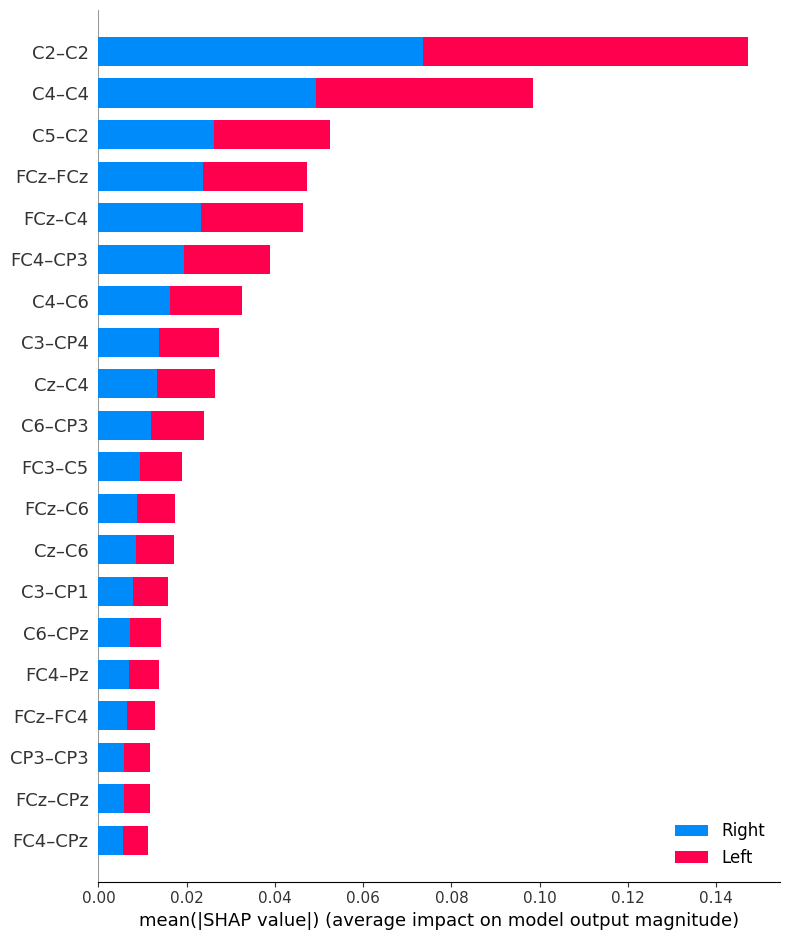


Top 5 Important Electrode Pairs:
C2–C2: SHAP = 0.0736
C4–C4: SHAP = 0.0493
C5–C2: SHAP = 0.0263
FCz–FCz: SHAP = 0.0236
FCz–C4: SHAP = 0.0232

Relevant Channels: C2–C2, C4–C4, C5–C2, FCz–FCz, FCz–C4


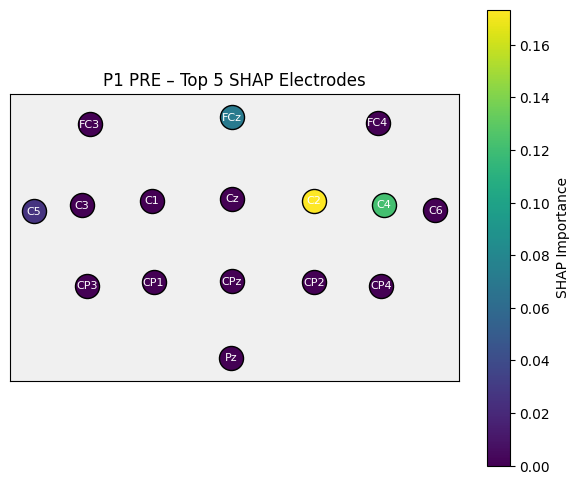


--- P1 POST ---
Fitting 5 folds for each of 128 candidates, totalling 640 fits


The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'warm_start': True}
Best Cross-Val Accuracy: 0.9375
Test Accuracy: 0.9494
              precision    recall  f1-score   support

           1       0.93      0.97      0.95        39
           2       0.97      0.93      0.95        40

    accuracy                           0.95        79
   macro avg       0.95      0.95      0.95        79
weighted avg       0.95      0.95      0.95        79



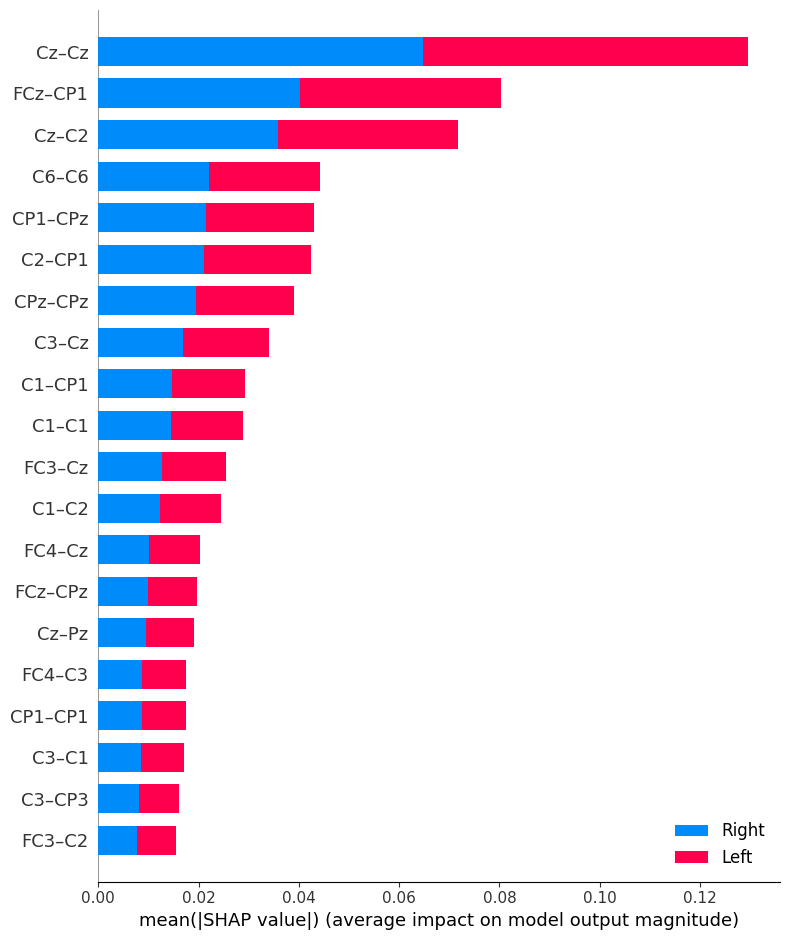


Top 5 Important Electrode Pairs:
Cz–Cz: SHAP = 0.0647
FCz–CP1: SHAP = 0.0402
Cz–C2: SHAP = 0.0359
C6–C6: SHAP = 0.0221
CP1–CPz: SHAP = 0.0215

Relevant Channels: Cz–Cz, FCz–CP1, Cz–C2, C6–C6, CP1–CPz


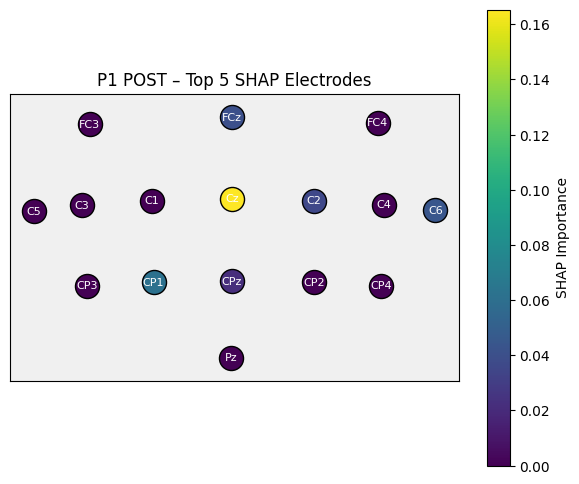


--- P2 PRE ---
Fitting 5 folds for each of 128 candidates, totalling 640 fits


The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'warm_start': True}
Best Cross-Val Accuracy: 0.7375
Test Accuracy: 0.7000
              precision    recall  f1-score   support

           1       0.69      0.72      0.71        40
           2       0.71      0.68      0.69        40

    accuracy                           0.70        80
   macro avg       0.70      0.70      0.70        80
weighted avg       0.70      0.70      0.70        80



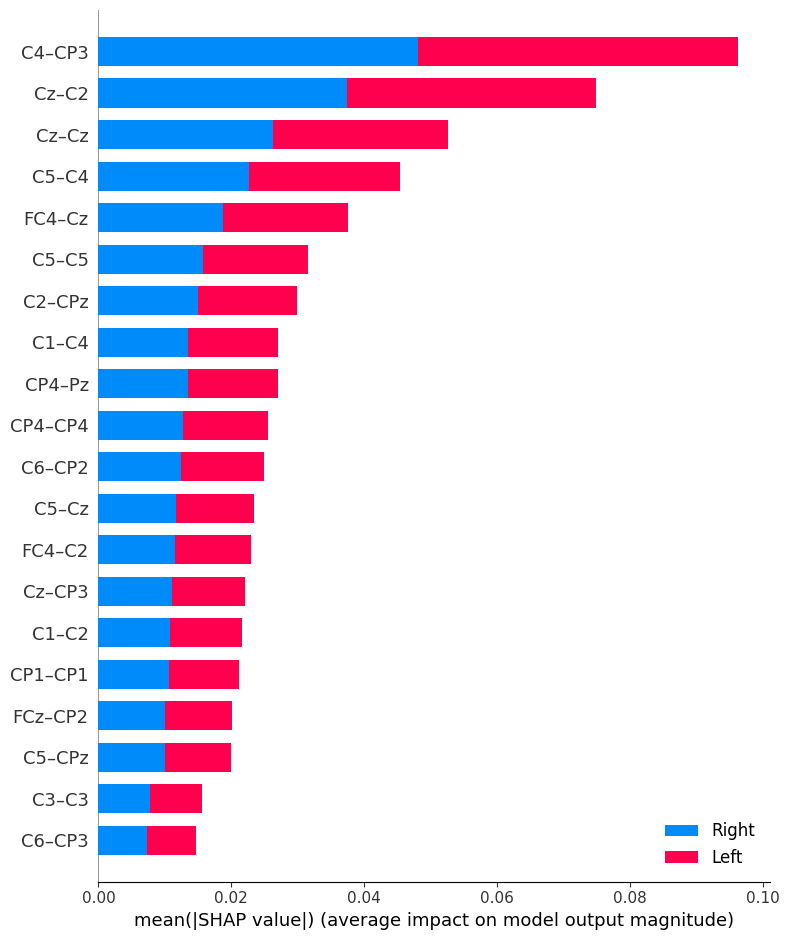


Top 5 Important Electrode Pairs:
C4–CP3: SHAP = 0.0482
Cz–C2: SHAP = 0.0374
Cz–Cz: SHAP = 0.0263
C5–C4: SHAP = 0.0227
FC4–Cz: SHAP = 0.0188

Relevant Channels: C4–CP3, Cz–C2, Cz–Cz, C5–C4, FC4–Cz


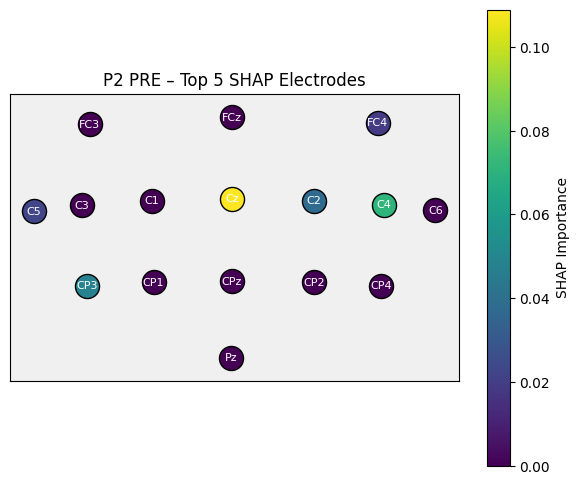


--- P2 POST ---
Fitting 5 folds for each of 128 candidates, totalling 640 fits


The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'warm_start': True}
Best Cross-Val Accuracy: 0.8000
Test Accuracy: 0.8875
              precision    recall  f1-score   support

           1       0.88      0.90      0.89        40
           2       0.90      0.88      0.89        40

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80



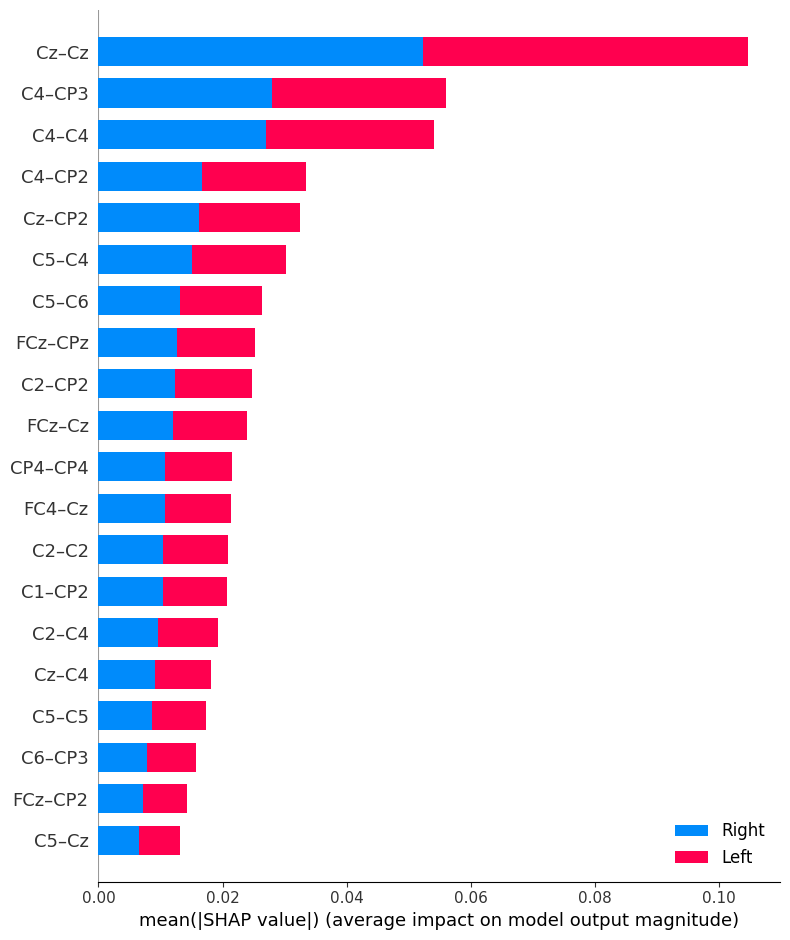


Top 5 Important Electrode Pairs:
Cz–Cz: SHAP = 0.0523
C4–CP3: SHAP = 0.0280
C4–C4: SHAP = 0.0270
C4–CP2: SHAP = 0.0167
Cz–CP2: SHAP = 0.0162

Relevant Channels: Cz–Cz, C4–CP3, C4–C4, C4–CP2, Cz–CP2


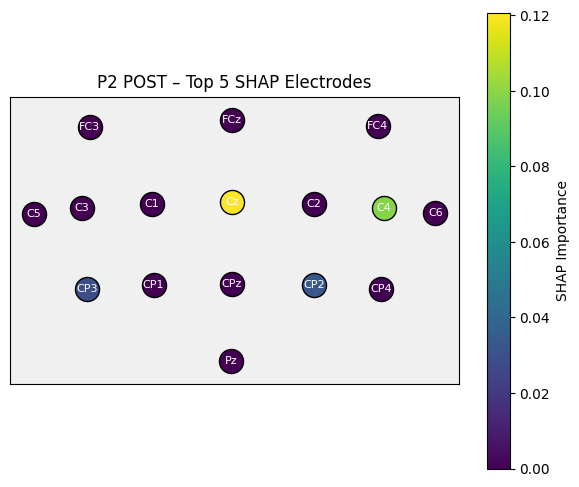


--- P3 PRE ---
Fitting 5 folds for each of 128 candidates, totalling 640 fits


The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'warm_start': True}
Best Cross-Val Accuracy: 0.9500
Test Accuracy: 0.9125
              precision    recall  f1-score   support

           1       0.90      0.93      0.91        40
           2       0.92      0.90      0.91        40

    accuracy                           0.91        80
   macro avg       0.91      0.91      0.91        80
weighted avg       0.91      0.91      0.91        80



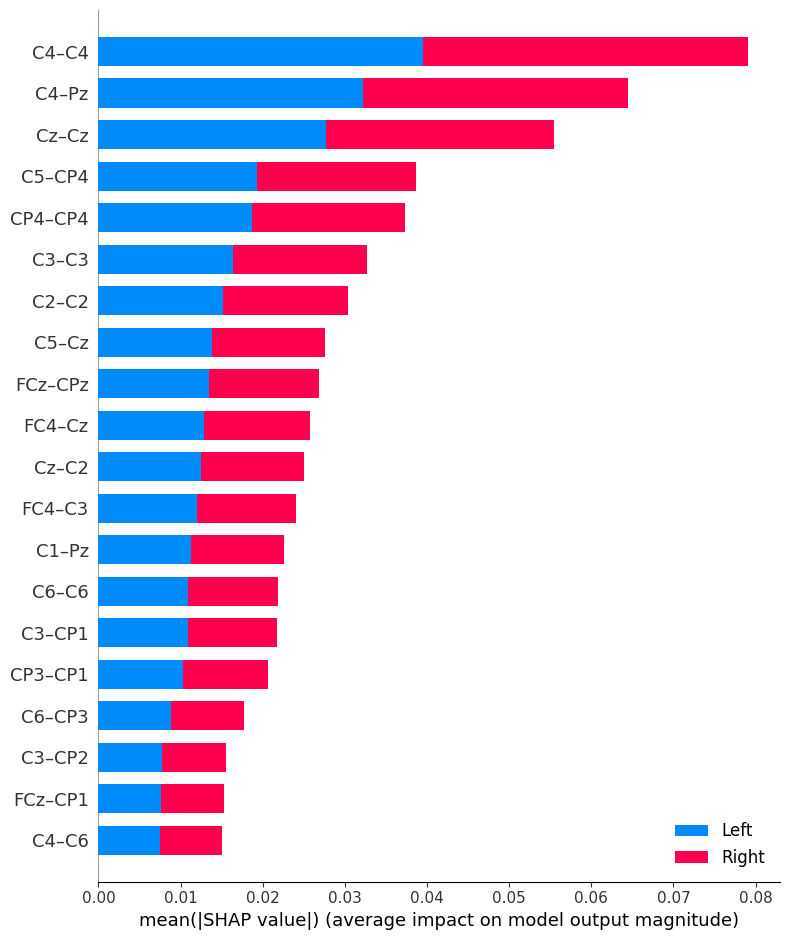


Top 5 Important Electrode Pairs:
C4–C4: SHAP = 0.0395
C4–Pz: SHAP = 0.0322
Cz–Cz: SHAP = 0.0277
C5–CP4: SHAP = 0.0193
CP4–CP4: SHAP = 0.0187

Relevant Channels: C4–C4, C4–Pz, Cz–Cz, C5–CP4, CP4–CP4


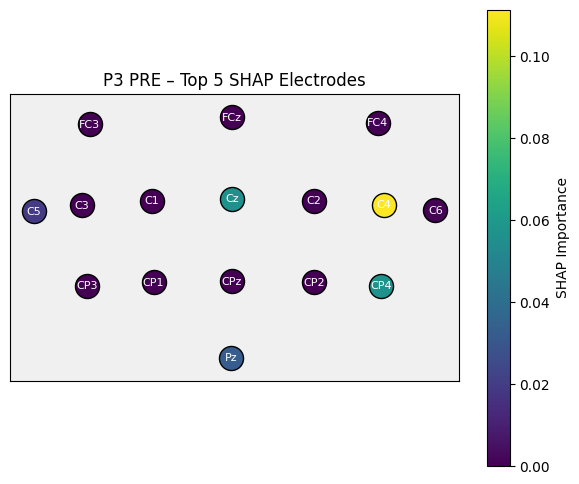


--- P3 POST ---
Fitting 5 folds for each of 128 candidates, totalling 640 fits


The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'warm_start': True}
Best Cross-Val Accuracy: 0.9125
Test Accuracy: 0.9500
              precision    recall  f1-score   support

           1       0.93      0.97      0.95        40
           2       0.97      0.93      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



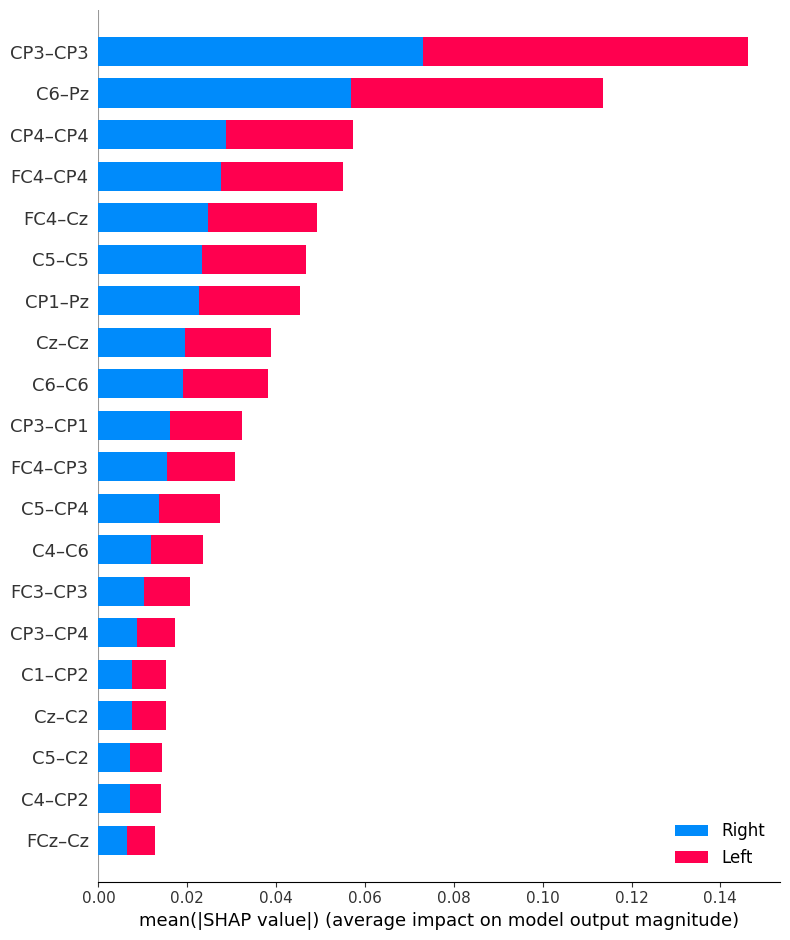


Top 5 Important Electrode Pairs:
CP3–CP3: SHAP = 0.0731
C6–Pz: SHAP = 0.0568
CP4–CP4: SHAP = 0.0287
FC4–CP4: SHAP = 0.0275
FC4–Cz: SHAP = 0.0247

Relevant Channels: CP3–CP3, C6–Pz, CP4–CP4, FC4–CP4, FC4–Cz


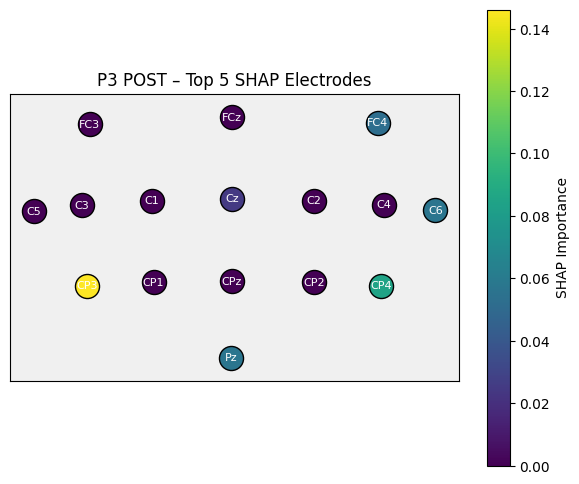

In [108]:
# Feature importance analysis per subject and session

for participant in participants:
    results[participant] = {}
    for session in sessions:
        print(f"\n--- {participant.upper()} {session.upper()} ---")

        # Get training and test epochs
        epochs_train = dataset[participant][session]['training']
        epochs_test = dataset[participant][session]['test']

        # Crop epochs to desired time window in seconds (relative to t=0)
        epochs_train = epochs_train.copy().crop(tmin=1.5, tmax=7.5)
        epochs_test = epochs_test.copy().crop(tmin=1.5, tmax=7.5)

        # Extract raw EEG data and labels
        X_train = epochs_train.get_data()
        X_test = epochs_test.get_data()
        y_train = epochs_train.events[:, 2]
        y_test = epochs_test.events[:, 2]

        # Compute SPD matrices
        X_train_spd = compute_spd_matrices(X_train)
        X_test_spd = compute_spd_matrices(X_test)

        # Transform to tangent space
        ts = TangentSpace(metric='riemann')
        X_train_ts = ts.fit_transform(X_train_spd)
        X_test_ts = ts.transform(X_test_spd)

        # --- Grid Search ---
        rf = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [None, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'bootstrap': [True, False],
            'warm_start': [True, False]
        }

        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train_ts, y_train)
        best_rf = grid_search.best_estimator_

        print("Best Parameters:", grid_search.best_params_)
        print(f"Best Cross-Val Accuracy: {grid_search.best_score_:.4f}")

        # --- Evaluation ---
        y_pred = best_rf.predict(X_test_ts)
        acc = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))
        results[participant][session] = {
            'accuracy': acc,
            'best_params': grid_search.best_params_,
        }

        # Generate channel-pair names for SHAP
        def get_spd_feature_labels(ch_names):
            labels = []
            for i in range(len(ch_names)):
                for j in range(i, len(ch_names)):
                    labels.append(f"{ch_names[i]}–{ch_names[j]}")
            return labels

        # Generate feature names for current subject/session
        feature_labels = get_spd_feature_labels(ch_labels)

        # Create DataFrame with channel pair labels
        X_df = pd.DataFrame(X_train_ts, columns=feature_labels)

        # SHAP analysis
        explainer = shap.TreeExplainer(best_rf)
        shap_values = explainer.shap_values(X_df)

        # Bar plot summary per channel pair
        shap.summary_plot(shap_values, X_df, plot_type="bar", class_names=["Right", "Left"])

        # Get Top 5 Important Electrode Pairs 
        mean_shap = np.abs(shap_values[0]).mean(axis=0)
        top_indices = np.argsort(mean_shap)[-5:][::-1].flatten()

        print("\nTop 5 Important Electrode Pairs:")
        relevant_channels = []
        for idx in top_indices:
            pair = feature_labels[idx]
            print(f"{pair}: SHAP = {mean_shap[idx]:.4f}")
            relevant_channels.append(pair)

        print(f"\nRelevant Channels: {', '.join(relevant_channels)}")

        # Visualise Top Pair Importance on Topo Map with Circles
        topomap_values = np.array([mean_shap[idx] for idx in top_indices])
        top_weights = {e: 0 for e in ch_labels}
        for idx in top_indices:
            pair = feature_labels[idx]
            ch1, ch2 = pair.split("–")
            contrib = mean_shap[idx]
            top_weights[ch1] += contrib
            top_weights[ch2] += contrib

        # MNE topomap visualization with circular electrode markers
        # Create MNE info and apply standard montage
        info = mne.create_info(ch_names=ch_labels, sfreq=250, ch_types='eeg')
        montage = mne.channels.make_standard_montage('standard_1020')
        info.set_montage(montage)

        # Get 2D positions of electrodes
        layout = mne.channels.make_eeg_layout(info)
        xy = layout.pos[:, :2]  # Only take X, Y (ignore width/height)

        # Extract values for electrodes
        values = np.array([top_weights[ch] for ch in ch_labels])

        # Normalise and define colormap
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values))
        cmap = plt.cm.viridis

        # Plot as coloured circles
        fig, ax = plt.subplots(figsize=(6, 6))
        for (x, y), val in zip(xy, values):
            ax.scatter(x, y, color=cmap(norm(val)), s=300, edgecolor='k')

        # Add electrode labels
        for (x, y), label in zip(xy, ch_labels):
            ax.text(x, y, label, ha='center', va='center', fontsize=8, color='white')

        # Add colourbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
        cbar.set_label('SHAP Importance')

        # Aesthetic cleanup
        ax.set_title(f'{participant.upper()} {session.upper()} – Top 5 SHAP Electrodes')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_xlim(xy[:, 0].min() - 0.05, xy[:, 0].max() + 0.05)
        ax.set_ylim(xy[:, 1].min() - 0.05, xy[:, 1].max() + 0.05)
        ax.set_facecolor('#f0f0f0')

        plt.tight_layout()
        plt.show()

        # Save figures
        fig = ax.figure
        fig.get_axes()[0].set_title("") 
        fig.savefig(f'plots/{participant}_{session}_top_electrodes_SHAP.png', dpi=600, bbox_inches='tight')